# Word Embedding - Home Assigment
## Dr. Omri Allouche 2018. YData Deep Learning Course

[Open in Google Colab](https://colab.research.google.com/github/omriallouche/deep_learning_course/blob/master/DL_word_embedding_assignment.ipynb)
    
    
In this exercise, you'll use word vectors trained on a corpus of 380,000 lyrics of songs from MetroLyrics (https://www.kaggle.com/gyani95/380000-lyrics-from-metrolyrics).  
The dataset contains these fields for each song, in CSV format:
1. index
1. song
1. year
1. artist
1. genre
1. lyrics

Before doing this exercise, we recommend that you go over the "Bag of words meets bag of popcorn" tutorial (https://www.kaggle.com/c/word2vec-nlp-tutorial)

Other recommended resources:
- https://rare-technologies.com/word2vec-tutorial/
- https://www.kaggle.com/pierremegret/gensim-word2vec-tutorial

In [ ]:
!conda install spacy

In [ ]:
# Install needed packages
!pip install gensim

In [105]:
# import needed packages
import pandas as pd
import numpy as np
# import operator
# import multiprocessing
import logging
# from tqdm import tqdm
import re
import string
# import warnings
# warnings.filterwarnings("ignore")

import matplotlib.pyplot as plt
%matplotlib inline
 
import seaborn as sns
# sns.set_style("darkgrid")

from collections import Counter
# from scipy.spatial import distance

from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import ExtraTreesClassifier

In [ ]:
import spacy

from spacy.util import minibatch, compounding
from spacy.tokenizer import Tokenizer

In [102]:
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords

nltk.download('punkt')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to C:\Users\Omri
[nltk_data]     Allouche\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping tokenizers\punkt.zip.
[nltk_data] Downloading package stopwords to C:\Users\Omri
[nltk_data]     Allouche\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping corpora\stopwords.zip.


True

In [106]:
STOP_WORDS = set(stopwords.words('english'))
PUNCT = dict.fromkeys(map(ord, string.punctuation))
CPUS = multiprocessing.cpu_count()

In [ ]:
import gensim
from gensim.models import Word2Vec
from gensim.models import KeyedVectors
from gensim.test.utils import get_tmpfile
from gensim.scripts.glove2word2vec import glove2word2vec

logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.WARNING)

In [34]:
df = pd.read_csv('lyrics.csv', index_col=0)
print('df.shape:', df.shape)
print('df.columns:', df.columns)
df.head()

df.shape: (362237, 5)
df.columns: Index(['song', 'year', 'artist', 'genre', 'lyrics'], dtype='object')


,song,year,artist,genre,lyrics
index,,,,,
0,ego-remix,2009,beyonce-knowles,Pop,"Oh baby, how you doing?\nYou know I'm gonna cu..."
1,then-tell-me,2009,beyonce-knowles,Pop,"playin' everything so easy,\nit's like you see..."
2,honesty,2009,beyonce-knowles,Pop,If you search\nFor tenderness\nIt isn't hard t...
3,you-are-my-rock,2009,beyonce-knowles,Pop,"Oh oh oh I, oh oh oh I\n[Verse 1:]\nIf I wrote..."
4,black-culture,2009,beyonce-knowles,Pop,"Party the people, the people the party it's po..."


In [35]:
df = df.dropna().reset_index(drop=True)

### Exploratory Data Analysis
Let's examine the data a bit first. We can print the numbers, or plot a bar chart of the counts.

In [36]:
df.groupby('genre')['lyrics'].count().sort_values()

genre
Folk               2243
Indie              3149
R&B                3401
Other              5189
Electronic         7966
Jazz               7970
Country           14387
Metal             23759
Not Available     23941
Hip-Hop           24850
Pop               40466
Rock             109235
Name: lyrics, dtype: int64

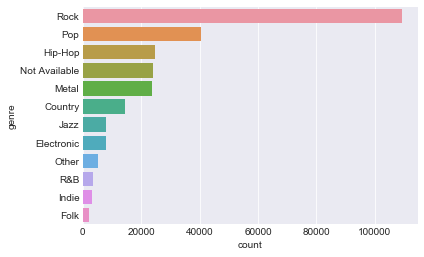

In [37]:
sns.countplot(data=df, y='genre', order=df.groupby('genre')['lyrics'].count().sort_values(ascending=False).index, orient='h')

We see that there are a lot of Rock songs, and very few Indie and Folk songs. How can this class imbalance affect our classifier performance?

This class imbalance might affect our algorithms if we're using only the most common words, since these words will be biased by their prevalance in Rock and Pop songs.  


We also see songs classified as "Not Available" or "Other". We should probably remove these from our dataset:

In [117]:
df = df[ ~df.genre.isin(['Not Available', 'Other'])]

Next, let's examine the distribution of the length of songs. We expect most songs to be around 3-5 minutes, and therefore have a certain length.

In [118]:
df['num_chars'] = df['lyrics'].str.len()

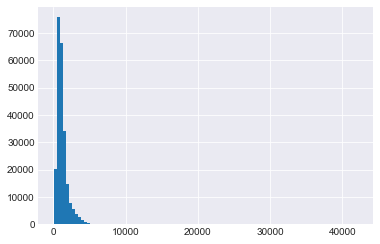

In [119]:
df['num_chars'].hist(bins=100)

We see a large pick at roughly 1000 characters, but a long tail of long documents, and quite a few documents that are very short. Let's check the CDF (Comulative Distribution Function):

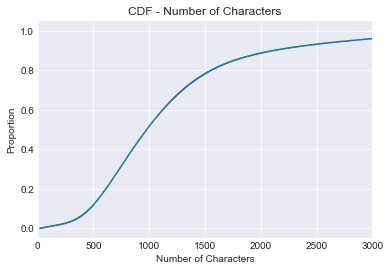

In [125]:
from scipy.stats import percentileofscore, scoreatpercentile
from numpy import sort, arange, nanpercentile, diff

def get_cdf(data, ignore_nan=False):
    if ignore_nan:
        data = data[ ~np.isnan(data) ]
    values = sort(data)
    percentiles = arange(len(values))/float(len(values))
    return values, percentiles

def plot_cdf(data, **kwargs):
    ignore_nan = kwargs.pop('ignore_nan', False)
    ax = kwargs.pop('ax', plt.gca())
    values, percentiles = get_cdf(data, ignore_nan=ignore_nan)
    ax.plot(values, percentiles, **kwargs )
    return values, percentiles

plot_cdf(df['num_chars']);
plt.xlim((0, 3000))
plt.xlabel('Number of Characters'); plt.ylabel('Proportion'); plt.title('CDF - Number of Characters');

We indeed see that some documents are very short (remember this is the number of characters, including spaces, punctuation marks and new line characters). We will examine the short and long documents later.

Next, let's examine the length of songs by genre, using a box plot:

(0, 4000)

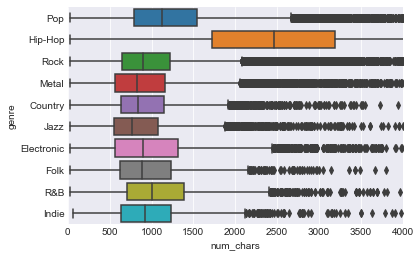

In [127]:
sns.boxplot(data=df, y='genre', x='num_chars')
plt.xlim(0, 4000);

We see that Hip-Hop songs tend to be much longer than the others, but don't see very large differences between other genres. We also note that there are many songs that are very long.

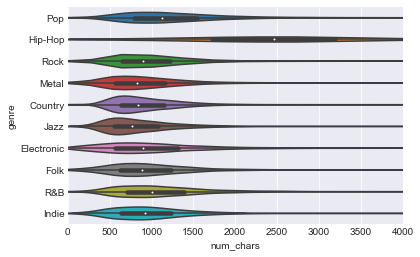

In [128]:
sns.violinplot(data=df, y='genre', x='num_chars')
plt.xlim(0, 4000);

We see that Electronic and Pop songs have large variability in length compared with Jazz and Country.

Next, let's examine the longest documents:

In [81]:
df.sort_values('num_chars').tail(50)

,song,year,artist,genre,lyrics,num_chars,num_words,average_word_length,num_unique_words
230082,b-boy-bouillabaisse,2008,beastie-boys,Hip-Hop,There's a girl over there\nWith long brown hai...,8948,1792,4.993304,713
48131,made-in-europe,2013,deep-purple,Rock,"A song called Highway Star, this one.\nNobody ...",8970,1819,4.931281,528
48133,made-in-japan,2013,deep-purple,Rock,"A song called Highway Star, this one.\nNobody ...",8970,1819,4.931281,528
224503,words-of-wisdom,2007,blink-182,Rock,Tom: I'm going to come back and I'm going to s...,9056,1812,4.997792,565
124383,give-me-back-my-sandwich,2006,five-iron-frenzy,Rock,"Up from the sands of the mighty Sahara comes,\...",9075,1701,5.335097,793
22674,who-s-on-first,2006,abbott-and-costello,Not Available,Abbott: How do you how do you like my ball clu...,9203,1658,5.550663,362
237309,the-vicki-eydie-show-around-the-world-istanbul...,1977,bette-midler,Rock,"""And now, And now, And now!\nComes my favorite...",9278,1692,5.483452,637
204509,manfred-mustermann,2016,blumentopf,Hip-Hop,Mir war von Anfang an klar\nMÃ¶chtest Du hier ...,9308,1621,5.742134,732
24209,rebirth,2010,bone-thugs-n-harmony,Hip-Hop,"Everybody wanna sound like, sound like, sound ...",9362,1718,5.449360,567
119613,rebirth,2013,bone-thugs,Hip-Hop,"Everybody wanna sound like, sound like, sound ...",9362,1718,5.449360,567


Let's examine a few of the records with many characters. We can see that these aren't actually songs - they are, for example, interviews or full albums. We don't expect our classifier to classify these correctly or learn from them, and better remove them from our corpus.

In [131]:
print( df.loc[255126].lyrics )

CUT TO:
*******[PLAY SONG "DIAL UP" AT THIS POINT]*******
[VISUAL]
The Boy lies, arms to his side, on his bed, looking at the ceiling
Spiders slowly drop from single strands of web from all the posts on the bed. It looks pretty. All of them dropping simultaneously swaying together. They whisper:
......where are you?
................who is this?
...don't slide
It's almost a song
*******[PLAY SONG "THE WORST GUYS" AT THIS POINT]*******
INT. MANSION - NIGHT
More people are at the house. People drinking and smoking. Shoes off. It's a Temple. Respect it
The back wall of the living room has been pushed into the wall, so there's a seamless transiting from living room to backyard patio
People sit on the swings underneath space heaters
EMILY is in the middle of the pool table. Swank plays pool around her. RUBEN is filming Marcus and Steve throwing things in the fire pit
AJ is djing in the middle of the living room
Some guy is running through the living room in just a towel. He is dripping water

In [85]:
print( df.loc[230543].lyrics )

Zane Lowe: Welcome back to Radio One, Maida Vale studio 4 here we are. Part of the reason we're here obviously because its the BBC but also because we have Studio 3 around the corner and you've got the band set up and going to perform some songs as well.
Eminem: It's super exciting to be here. I was trying to figure out how I was going to top the publicity of yours and Kanye's interview so I decided I was going to walk in here, pee on the floor, and leave. I'm peeing right now. Alright see you guys later!
ZL: Seeing you with the band, and seeing you perform the other night at the awards show and seeing you on the mic, it was, I don't think I've ever seen you more alive on the mic. It was full of energy and in the moment. What I noticed was as well was spitting live with the band behind you seemed to free you up a lot more. Are you feeling that way?
E: I think performing has gotten a lot different, it's gotten better with the band because there's just more elements to it and being it is

In [90]:
print( df.query('num_chars>4000 & num_chars<4500').iloc[2]['lyrics'] )

Hey yo man, remember that shit Eazy did a while back
Motherfuckers said it wasn't gonna work
That crazy shit, yeah the stupid shit
Hey yo Eazy! (Yo!)
Hey man why don't you come off the piano for a minute
And bust this crazy shit
Woke up quick at about noon
Just thought that I had to be in Compton soon
I gotta get drunk before the day begins
Before my mother starts bitchin' about my friends
About to go and damn near went blind
Young niggaz at the pad throwin' up gang signs
Ran in the house and grabbed my clip
With the Mac-10 on the side of my hip
Bailed outside and pointed my weapon
Just as I thought, the fools kept steppin'
Jumped in the fo' hit the juice on my ride
I got front back and side to side
Then I let the Alpine play
Bumpin' new shit by NWA
It was "Gangsta Gangsta" at the top of the list
Then I played my own shit, it went somethin' like this
Cruisin' down the street in my six-fo'
Jockin' the bitches, slappin' the hoes
Went to the park to get the scoop
Knuckleheads out there co

On the other end, let's examine a few of the short songs in our dataset:

In [133]:
df.sort_values('num_chars').head(10)

,song,year,artist,genre,lyrics,num_chars,num_words,average_word_length,num_unique_words,sent
165195,iaoea,2006,edaiaoidee,Rock,",\n,\n,\n,\n, ,\n,\n, ,\n, ,",21,11,1.909091,1,[]
41625,thrashers,2006,death-angel,Metal,[No lyrics available],21,3,7.000000,3,"[no, lyrics, available]"
101846,steel-guitar-rag,2007,buck-owens,Country,It's an instrumental.,21,3,7.000000,3,"[it, instrumental]"
262610,sequence-7,2007,fates-warning,Rock,[Music - Jim Matheos],21,4,5.250000,4,"[music, jim, matheos]"
155332,iaa-iieyie-ooiai,2006,eeii,Rock,",\n.\n, -\n.\n,\n,\n.\n,\n,\n,",21,11,1.909091,3,[]
6396,idaethaey,2006,adaaeaaineay-iaidiia,Rock,",\n"" , ""\n,\n,\n.\n.\n, , ,",21,11,1.909091,3,[]
86188,aaiu-ioeduouo-aaadae,2006,aeena,Rock,",\n.\n,\n,\n?\n?\n,\n.\n,\n.\n,",21,11,1.909091,3,[]
248814,aac-oaay,2006,adey,Rock,",\n.\n-\n.\n,\n...\n, , ,\n.",21,10,2.100000,4,[]
213710,planet-caravan,2007,cable,Rock,[Black Sabbath cover],21,3,7.000000,3,"[black, sabbath, cover]"
6382,oae-aaeaei,2006,adaaeaaineay-iaidiia,Rock,",\n,\n,\n,\n,\n,\n,\n, ,\n,\n,",21,11,1.909091,1,[]


We see that many songs have only special characters and no actual lyrics. We also see comments in [] blocks. We'd like to make sure we remove these from our data.

In [134]:
df = df[ df['num_chars']>200 ]

Below we look at the number of words and unique number of words for each genre - NOT IMPORTANT.

In [59]:
df['num_words'] = df['lyrics'].apply(lambda x: len(x.replace('\n', ' ').split()) )

In [66]:
df['num_unique_words'] = df['lyrics'].apply(lambda x: len( set( x.replace('\n', ' ').lower().split()) ) )

In [60]:
df['average_word_length'] = df['num_chars'] / df['num_words']

In [67]:
df.head()

,song,year,artist,genre,lyrics,num_chars,num_words,average_word_length,num_unique_words
0,ego-remix,2009,beyonce-knowles,Pop,"Oh baby, how you doing?\nYou know I'm gonna cu...",1961,433,4.528868,146
1,then-tell-me,2009,beyonce-knowles,Pop,"playin' everything so easy,\nit's like you see...",1270,258,4.922481,135
2,honesty,2009,beyonce-knowles,Pop,If you search\nFor tenderness\nIt isn't hard t...,827,170,4.864706,101
3,you-are-my-rock,2009,beyonce-knowles,Pop,"Oh oh oh I, oh oh oh I\n[Verse 1:]\nIf I wrote...",2344,522,4.490421,131
4,black-culture,2009,beyonce-knowles,Pop,"Party the people, the people the party it's po...",1540,312,4.935897,54


(0, 10)

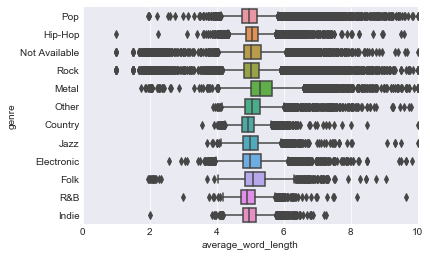

In [65]:
sns.boxplot(data=df, y='genre', x='average_word_length')
plt.xlim(0, 10)

(0, 200)

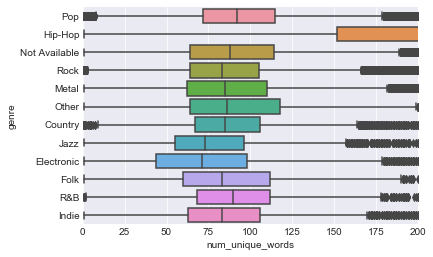

In [70]:
sns.boxplot(data=df, y='genre', x='num_unique_words')
plt.xlim(0, 200)

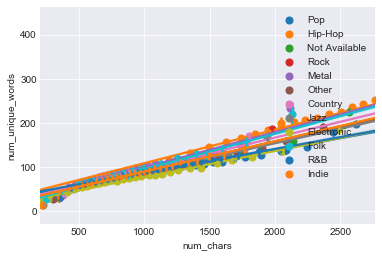

In [74]:
for genre in df.genre.unique():
    d = df[ df.genre==genre ]
    sns.regplot(d['num_chars'], y=d['num_unique_words'], x_bins=30, label=genre)
plt.legend()

### Sample data 
In order to explore efficiently, we don't need all of the data we have. Let's create a subset of it, making sure the number of songs from each category generally matches. 

We first focus only on the most common genres - Rock, Pop, Hip-Hop, Metal and Country.

In [150]:
df = df[ df.genre.isin(['Rock', 'Pop', 'Hip-Hop', 'Metal', 'Country'])]
genre_counts = df['genre'].value_counts()

In [151]:
weights = [ 1/genre_counts.loc[v] for v in df.genre.values ]

In [160]:
s = df.sample(n=50000, random_state=10, weights=weights)

In [161]:
s.genre.value_counts()

Rock       11814
Pop        10556
Hip-Hop     9799
Metal       9523
Country     8308
Name: genre, dtype: int64

In [162]:
df = s

### Train word vectors
Train word vectors using the Skipgram Word2vec algorithm and the gensim package.
Make sure you perform the following:
- Tokenize words
- Lowercase all words
- Remove punctuation marks
- Remove rare words
- Remove stopwords

Use 300 as the dimension of the word vectors. Try different context sizes.

In [135]:
def nltk_tokenize(text):
    text = re.sub("[^a-zA-Z]"," ", text)
    text = re.sub("[\[*\]]"," ", text)
    text = text.translate(PUNCT)
    return [word.lower() for word in nltk.word_tokenize(text) if word not in STOP_WORDS]

In [136]:
print( df.iloc[0].lyrics )

Oh baby, how you doing?
You know I'm gonna cut right to the chase
Some women were made but me, myself
I like to think that I was created for a special purpose
You know, what's more special than you? You feel me
It's on baby, let's get lost
You don't need to call into work 'cause you're the boss
For real, want you to show me how you feel
I consider myself lucky, that's a big deal
Why? Well, you got the key to my heart
But you ain't gonna need it, I'd rather you open up my body
And show me secrets, you didn't know was inside
No need for me to lie
It's too big, it's too wide
It's too strong, it won't fit
It's too much, it's too tough
He talk like this 'cause he can back it up
He got a big ego, such a huge ego
I love his big ego, it's too much
He walk like this 'cause he can back it up
Usually I'm humble, right now I don't choose
You can leave with me or you could have the blues
Some call it arrogant, I call it confident
You decide when you find on what I'm working with
Damn I know I'm kil

In [137]:
" ".join( nltk_tokenize( df.iloc[0].lyrics ) )

'oh baby you know i gon na cut right chase some women made i like think i created special purpose you know special you feel it baby let get lost you need call work cause boss for real want show feel i consider lucky big deal why well got key heart but gon na need i rather open body and show secrets know inside no need lie it big wide it strong fit it much tough he talk like cause back he got big ego huge ego i love big ego much he walk like cause back usually i humble right i choose you leave could blues some call arrogant i call confident you decide find i working damn i know i killing legs better yet thighs matter fact smile maybe eyes boy site see kind something like it big wide it strong fit it much tough i talk like cause i back i got big ego huge ego but love big ego much i walk like cause i back i i walk like cause i back i i talk like cause i back i i back i back i walk like cause i back it big wide it strong fit it much tough he talk like cause back he got big ego huge ego hug

In [138]:
df['sent'] = df['lyrics'].apply(nltk_tokenize)

Let's find the most common and rare words. We can count each genre separately, and then easily combine the counts to get the backgroun distribution. We need to remember that the number of songs in each genre is different.

In [403]:
df['num_words'] = df.sent.apply(lambda x: len(x))
df = df[ df.num_words > 5]

,song,year,artist,genre,lyrics,num_chars,num_words,average_word_length,num_unique_words,sent
204183,little-girls,2008,annie,Pop,"Little girls,\nLittle girls.\nEverywhere I tur...",995,129,5.467033,111,"[little, girls, little, girls, everywhere, i, ..."
6118,whoo-kid-kayslay-shit,2006,50-cent,Hip-Hop,"[Intro - 50 Cent - talking, breathing noises i...",1355,179,5.000000,184,"[intro, cent, talking, breathing, noises, back..."
166369,taste-the-tears-thunderpuss-remix,2006,amber,Pop,How could you cause me so much pain?\nAnd leav...,1113,149,4.991031,85,"[how, could, cause, much, pain, and, leave, he..."
198430,talk-about-it,2006,glenn-hughes,Rock,TALK ABOUT IT\nIn the coldness of love's sweet...,597,78,4.814516,72,"[talk, about, it, in, coldness, love, sweet, i..."
127803,something-goin-on-here,2008,aaron-pritchett,Country,"I've thought about it, I've analyzed it\nYou k...",975,105,5.186170,101,"[i, thought, i, analyzed, you, kissin, verifie..."


Finally, let's train word vectors on our new corpus. 

In [231]:
!pip install gensim

  Retrying (Retry(total=4, connect=None, read=None, redirect=None, status=None)) after connection broken by 'NewConnectionError('<pip._vendor.urllib3.connection.VerifiedHTTPSConnection object at 0x0000017053BD8780>: Failed to establish a new connection: [Errno 11001] getaddrinfo failed',)': /simple/gensim/
  Retrying (Retry(total=3, connect=None, read=None, redirect=None, status=None)) after connection broken by 'NewConnectionError('<pip._vendor.urllib3.connection.VerifiedHTTPSConnection object at 0x0000017053BD84A8>: Failed to establish a new connection: [Errno 11001] getaddrinfo failed',)': /simple/gensim/
  Retrying (Retry(total=2, connect=None, read=None, redirect=None, status=None)) after connection broken by 'NewConnectionError('<pip._vendor.urllib3.connection.VerifiedHTTPSConnection object at 0x0000017053BD86D8>: Failed to establish a new connection: [Errno 11001] getaddrinfo failed',)': /simple/gensim/
  Retrying (Retry(total=1, connect=None, read=None, redirect=None, status=No

In [277]:
import gensim
w2v = gensim.models.Word2Vec(df.sent, sg=1, min_count=4, size=50, workers=CPUS*2-1)

### Review most similar words
Get initial evaluation of the word vectors by analyzing the most similar words for a few interesting words in the text. 

Choose words yourself, and find the most similar words to them.

In [278]:
words_to_check = ['love', 'hate', 'lonely', 'heartache', 'success', 'guitar', 'god', 'beer', 'gun', 'police']
for word in words_to_check:
    print(word, ' -> ', ['{} ({:.2f}), '.format(tup[0], tup[1]) for tup in w2v.wv.similar_by_word(word, topn=5)])
    print()

love  ->  ['shinola (0.89), ', 'ermesinde (0.87), ', 'superwoman (0.86), ', 'madly (0.86), ', 'dangerously (0.86), ']

hate  ->  ['contention (0.85), ', 'attracted (0.83), ', 'degrade (0.82), ', 'generates (0.82), ', 'misuse (0.82), ']

lonely  ->  ['alone (0.88), ', 'lowdown (0.84), ', 'lonelier (0.84), ', 'longin (0.82), ', 'heartbreak (0.81), ']

heartache  ->  ['unbreak (0.83), ', 'longin (0.80), ', 'heartbreaks (0.80), ', 'lowdown (0.79), ', 'heartaches (0.79), ']

success  ->  ['valuable (0.84), ', 'lectures (0.83), ', 'hopefully (0.82), ', 'consideration (0.82), ', 'realistic (0.82), ']

guitar  ->  ['harmonica (0.88), ', 'fiddle (0.82), ', 'violin (0.82), ', 'acoustic (0.81), ', 'mandolin (0.81), ']

god  ->  ['lord (0.88), ', 'forgives (0.84), ', 'blessed (0.84), ', 'blessing (0.84), ', 'almighty (0.83), ']

beer  ->  ['whiskey (0.83), ', 'drink (0.83), ', 'chug (0.82), ', 'beers (0.81), ', 'bar (0.81), ']

gun  ->  ['shot (0.82), ', 'lawman (0.82), ', 'bullet (0.81), ', 'guns

In [242]:
import gensim
w2v = gensim.models.Word2Vec(df.sent, sg=1, min_count=5, size=300, workers=CPUS*2-1)

In [243]:
words_to_check = ['love', 'hate', 'lonely', 'heartache', 'success', 'guitar', 'god', 'beer', 'gun', 'police']
for word in words_to_check:
    print(word, ' -> ', ['{} ({:.2f}), '.format(tup[0], tup[1]) for tup in w2v.wv.similar_by_word(word, topn=5)])
    print()

love  ->  ['unconditional (0.48), ', 'tenderness (0.45), ', 'tenderly (0.43), ', 'untrue (0.42), ', 'certainly (0.42), ']

hate  ->  ['breeds (0.45), ', 'frenzy (0.44), ', 'hateful (0.44), ', 'successful (0.43), ', 'hatred (0.43), ']

lonely  ->  ['lonesome (0.51), ', 'alone (0.46), ', 'dreary (0.44), ', 'unsure (0.43), ', 'deserted (0.43), ']

heartache  ->  ['heartaches (0.45), ', 'sorrow (0.44), ', 'unsure (0.41), ', 'heartbreak (0.40), ', 'aches (0.37), ']

success  ->  ['invest (0.45), ', 'effort (0.44), ', 'acknowledge (0.43), ', 'failures (0.42), ', 'interest (0.42), ']

guitar  ->  ['saxophone (0.59), ', 'keyboards (0.54), ', 'banjo (0.52), ', 'vocals (0.52), ', 'fiddle (0.51), ']

god  ->  ['lord (0.52), ', 'bless (0.50), ', 'almighty (0.49), ', 'praises (0.47), ', 'emmanuel (0.46), ']

beer  ->  ['chug (0.58), ', 'bourbon (0.47), ', 'drinkin (0.46), ', 'bartender (0.45), ', 'beers (0.45), ']

gun  ->  ['guns (0.53), ', 'aimed (0.50), ', 'bucked (0.45), ', 'rifle (0.45), ', 'b

### Word Vectors Algebra
We've seen in class examples of algebraic games on the word vectors (e.g. man - woman + king = queen ). 

Try a few vector algebra terms, and evaluate how well they work. Try to use the Cosine distance and compare it to the Euclidean distance.

In [279]:
model = w2v

In [280]:
model.wv.most_similar_cosmul(positive=['woman', 'king'], negative=['man'])[0]
model.wv.most_similar(positive=['woman', 'king'], negative=['man'])[0]
model.wv.most_similar_cosmul(positive=['girl', 'brother'], negative=['boy'])[0]
model.wv.most_similar_cosmul(positive=["man","daughter"],negative=["woman"])
model.wv.most_similar(positive=['king', 'woman'], negative=['man'])
model.wv.most_similar(positive=['mother', 'he'], negative=['father'])
model.wv.most_similar(positive=['strong', 'small'], negative=['weak'])

[('riverboat', 0.7404574155807495),
 ('towns', 0.7367786169052124),
 ('squatin', 0.7236427068710327),
 ('rattler', 0.7200068235397339),
 ('storeys', 0.7182438373565674),
 ('piddly', 0.7121356725692749),
 ('broncs', 0.7105759382247925),
 ('big', 0.709046483039856),
 ('extraordinary', 0.7045096158981323),
 ('uphill', 0.700311541557312)]

## Sentiment Analysis
Estimate sentiment of words using word vectors.  
In this section, we'll use the SemEval-2015 English Twitter Sentiment Lexicon.  
The lexicon was used as an official test set in the SemEval-2015 shared Task #10: Subtask E, and contains a polarity score for words in range -1 (negative) to 1 (positive) - http://saifmohammad.com/WebPages/SCL.html#OPP

Build a classifier for the sentiment of a word given its word vector. Split the data to a train and test sets, and report the model performance on both sets.

We start by downloading the data and extracting it. We will create a dictionary with the keys are the words and the values are their sentiment scores.  
Note that the sentiment dataset contains terms of multiple words and hashtags - we will remove these from the dataset.

In [248]:
!wget http://saifmohammad.com/WebDocs/lexiconstoreleaseonsclpage/SemEval2015-English-Twitter-Lexicon.zip
!unzip SemEval2015-English-Twitter-Lexicon.zip
!head SemEval2015-English-Twitter-Lexicon/SemEval2015-English-Twitter-Lexicon.txt

'wget' is not recognized as an internal or external command,
operable program or batch file.
unzip:  cannot find or open SemEval2015-English-Twitter-Lexicon.zip, SemEval2015-English-Twitter-Lexicon.zip.zip or SemEval2015-English-Twitter-Lexicon.zip.ZIP.
head: cannot open 'SemEval2015-English-Twitter-Lexicon/SemEval2015-English-Twitter-Lexicon.txt' for reading: No such file or directory


In [ ]:
!wget http://nlp.stanford.edu/data/glove.twitter.27B.zip
!unzip glove.twitter.27B.zip

In [ ]:
# https://radimrehurek.com/gensim/scripts/glove2word2vec.html
if False:
    tmp_file = get_tmpfile("w2v.twitter.27B.100d.txt")
    glove2word2vec('glove.twitter.27B.100d.txt', tmp_file)
    model = KeyedVectors.load_word2vec_format(tmp_file)

In [281]:
with open('SemEval2015-English-Twitter-Lexicon.txt', 'r') as f:
    scores, twitter_sentiment_words = zip(*[line.strip().split() for line in f.readlines()])

twitter_sentiment_words = [w[1:] if w.startswith('#') else w for w in twitter_sentiment_words]
X = []
y = []

for i in range(len(scores)):
    if twitter_sentiment_words[i] in model:
        X.append(model[twitter_sentiment_words[i]])
        y.append(scores[i])

X = np.array(X, dtype='float')
y = np.array(y, dtype='float')

X_train, X_test, y_train, y_test = \
  train_test_split(X, y, test_size=0.1, random_state=0) # We used 10,000 songs from each category - 1,000 songs in the test set seem like a lot. 

Next let's build a regressor to predict the sentiment of a word from its word vector. We use the word vectors trained on our corpus of song lyrics.  
Let's try a few different algorithms, and choose the one with the smallest MSE on the test set:

In [282]:
from sklearn import metrics

from sklearn.neural_network import MLPRegressor
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.svm import SVR

models = [
    LinearRegression(),
    MLPRegressor(max_iter=1000, tol=1e-5, hidden_layer_sizes=(300,200,100)),
    RandomForestRegressor(),
    GradientBoostingRegressor(),
    SVR()
]
score = {}
for model in models:
    model_name = str(model).split('(')[0]
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    score[model_name] = metrics.mean_squared_error(y_test, y_pred)

print(score)

{'LinearRegression': 0.1461719188325224, 'MLPRegressor': 0.1400196267916689, 'RandomForestRegressor': 0.1328502358965349, 'GradientBoostingRegressor': 0.13311542397256862, 'SVR': 0.14364863448496495}


In [283]:
model = models[-1]

Use your trained model from the previous question to predict the sentiment score of words in the lyrics corpus that are not part of the original sentiment dataset. Review the words with the highest positive and negative sentiment. Do the results make sense?

In [285]:
num_words = 0
test_words = []
for w, _ in freqs_bg.most_common(10000):
    if w not in twitter_sentiment_words and w in w2v:
        test_words.append(w)
        num_words += 1
    if num_words == 1000:
        break

similar_words_features = np.array([w2v[w] for w in test_words], 'float')
sentiment_scores = model.predict(similar_words_features)

df_predicted_sentiment = pd.Series(sentiment_scores, index=test_words)

print(' --- top 20 negative sentiment score --')
print( df_predicted_sentiment.sort_values().head(20) )

print(' --- top 20 positive sentiment score --')
print( df_predicted_sentiment.sort_values().tail(20) )

 --- top 20 negative sentiment score --
insane      -0.953164
murder      -0.881354
brain       -0.851091
dead        -0.730255
dogs        -0.674408
blame       -0.667665
bleed       -0.647019
shots       -0.630486
knife       -0.618161
escape      -0.609505
killing     -0.608435
screaming   -0.597452
burns       -0.577888
dog         -0.576041
cries       -0.572600
dry         -0.566243
suck        -0.565417
drown       -0.552088
police      -0.548990
bones       -0.544439
dtype: float64
 --- top 20 positive sentiment score --
glory        0.759939
bells        0.776034
together     0.811427
lift         0.825720
la           0.825809
stars        0.826998
ladies       0.828676
shine        0.834932
shining      0.839877
jesus        0.870399
magic        0.900729
il           0.906875
sing         0.909356
brand        0.911102
bright       0.923421
per          0.931616
lo           0.932336
che          1.019308
special      1.026534
christmas    1.253884
dtype: float64


### Visualize Word Vectors
In this section, you'll plot words on a 2D grid based on their inner similarity. We'll use the tSNE transformation to reduce dimensions from 300 to 2. You can get sample code from https://www.kaggle.com/pierremegret/gensim-word2vec-tutorial or other tutorials online.

Perform the following:
- Keep only the 3,000 most frequent words (after removing stopwords)
- For this list, compute for each word its relative abundance in each of the genres
- Compute the ratio between the proportion of each word in each genre and the proportion of the word in the entire corpus (the background distribution)
- Pick the top 50 words for each genre. These words give good indication for that genre. Join the words from all genres into a single list of top significant words. 
- Compute tSNE transformation to 2D for all words, based on their word vectors
- Plot the list of the top significant words in 2D. Next to each word output its text. The color of each point should indicate the genre for which it is most significant.

You might prefer to use a different number of points or a slightly different methodology for improved results.  
Analyze the results.

In [141]:
!pip install tqdm

You are using pip version 19.0.2, however version 19.0.3 is available.
You should consider upgrading via the 'python -m pip install --upgrade pip' command.


In [164]:
from tqdm import tqdm 

freqs = {}
for i,r in tqdm(df.iterrows()):
    if r.genre not in freqs:
        freqs[ r.genre ] = Counter()
    freqs[ r.genre ].update(r.sent)



0it [00:00, ?it/s]

239it [00:00, 2298.59it/s]

572it [00:00, 2511.28it/s]

1138it [00:00, 2995.34it/s]

1614it [00:00, 3341.95it/s]

2166it [00:00, 3759.90it/s]

2616it [00:00, 3914.02it/s]

3071it [00:00, 4042.05it/s]

3482it [00:00, 4014.89it/s]

4139it [00:00, 4507.84it/s]

4771it [00:01, 4886.83it/s]

5387it [00:01, 5157.63it/s]

6004it [00:01, 5368.40it/s]

6559it [00:01, 4957.18it/s]

7074it [00:01, 4537.21it/s]

7681it [00:01, 4862.00it/s]

8354it [00:01, 5254.26it/s]

8968it [00:01, 5433.96it/s]

9530it [00:02, 4489.43it/s]

10019it [00:02, 4452.29it/s]

10493it [00:02, 4336.07it/s]

10947it [00:02, 4295.87it/s]

11391it [00:02, 4144.05it/s]

11817it [00:02, 3699.62it/s]

12267it [00:02, 3868.10it/s]

12750it [00:02, 4072.36it/s]

13379it [00:02, 4515.25it/s]

13855it [00:03, 4383.62it/s]

14311it [00:03, 4190.89it/s]

14748it [00:03, 4194.31it/s]

15224it [00:03, 4302.71it/s]

15663it [00:03, 4278.14it/s]

16297it [00:03, 4698.67it/s]

16784it [00:03, 3777.15it/s]

17203it 

In [168]:
freqs_bg = Counter()
[freqs_bg.update(v) for v in freqs.values()];

Let's check the most common words for each genre. Remember, here we only consider word occurrences. A word might be common in all genres. We will later examine words that are common in a specific genre more than the others.

In [169]:
freqs_bg.most_common(20)

[('i', 547077),
 ('and', 95783),
 ('you', 80494),
 ('like', 77095),
 ('know', 65213),
 ('got', 64531),
 ('love', 63584),
 ('get', 53175),
 ('the', 48728),
 ('na', 44967),
 ('oh', 42762),
 ('one', 40394),
 ('see', 39686),
 ('but', 39556),
 ('go', 39009),
 ('it', 38756),
 ('time', 38213),
 ('never', 36731),
 ('let', 35949),
 ('cause', 33524)]

In [173]:
_ = {genre: [v[0] for v in counts.most_common(20)] for genre, counts in freqs.items()}
pd.DataFrame(_)

,Country,Hip-Hop,Metal,Pop,Rock
0,i,i,i,i,i
1,and,like,the,love,and
2,love,got,and,and,you
3,you,get,you,you,know
4,know,and,life,oh,love
5,but,know,one,know,like
6,like,you,time,like,got
7,got,nigga,see,na,oh
8,one,cause,we,got,the
9,time,na,like,baby,it


Can you spot the genre with the least amount of "love"?

To find the most common words for each genre, we will search for words that are both common and have a large ratio between their relative frequency in a genre and their relative frequency in the background.


In [218]:
total_counts = {genre: sum(counts.values()) for genre, counts in freqs.items()}
total_counts

{'Country': 953578,
 'Hip-Hop': 3220432,
 'Metal': 1115887,
 'Pop': 1716150,
 'Rock': 1456006}

In [201]:
total_counts_bg = sum(freqs_bg.values())
word_freq = pd.DataFrame({w: freqs_bg[w] / total_counts_bg for w, v in freqs_bg.most_common(2000)}, index=['bg']).T
word_freq.head()

,bg
a,0.002656
about,0.000113
across,0.000237
act,0.000257
actin,0.000072


In [220]:
for genre in total_counts.keys():
    word_freq[genre] = [ freqs[genre].get(w, 0)/total_counts[genre]/r['bg'] for w,r in word_freq.iterrows() ]

In [286]:
genres = df.genre.unique()
for genre in genres:
    print( genre )
    print( ", ".join(word_freq.sort_values(genre, ascending=False).index[:50].values ) )
    print()

Pop
amor, moi, che, puedo, pi, qui, quiero, dah, tus, ti, tout, ce, ser, ba, per, hoy, comme, toi, non, qu, ahora, noche, il, voy, vas, pum, eres, mmm, ai, tu, cuando, vida, et, ni, tiempo, vez, est, siempre, je, para, una, wa, eh, si, ga, pas, mis, dum, ooh, oooh

Hip-Hop
dre, yuh, niggas, tha, nigga, niggaz, rappers, gangsta, killa, hoes, pussy, glock, thugs, bitches, busta, nuh, homie, thug, yup, homies, hoe, fo, motherfuckers, motherfuckin, ballin, clip, flex, squad, rapper, pimp, mic, fi, bitch, mack, wit, mc, benz, bust, dope, hustle, beef, dick, weed, rap, shit, blunt, chrome, haters, playa, lil

Rock
seemed, saturday, liar, promises, california, likes, johnny, romance, mary, blues, saved, crawl, awake, changing, does, machine, wonderful, sleeping, wasted, lied, reasons, alive, says, changes, anyway, losing, oo, quite, someday, shines, hiding, band, anymore, darlin, everyone, shame, highway, mystery, well, voices, ga, laughing, brings, underneath, somehow, tide, american, were, 

In [299]:
import itertools
words = list(set(list(itertools.chain.from_iterable([word_freq.sort_values(genre, ascending=False).index[:50].values for genre in genres]))))

In [322]:
from sklearn.manifold import TSNE
X = [w2v[w] for w in words]
X_embedded = TSNE(n_components=2).fit_transform(X)

In [323]:
X_embedded.shape

(245, 2)

In [349]:
colors = ['r', 'g', 'b', 'k', 'y']
c = [colors[list(genres).index(word_freq.loc[w].argmax())] for w in words]
word_genre = np.array( [word_freq.loc[w].argmax() for w in words] )

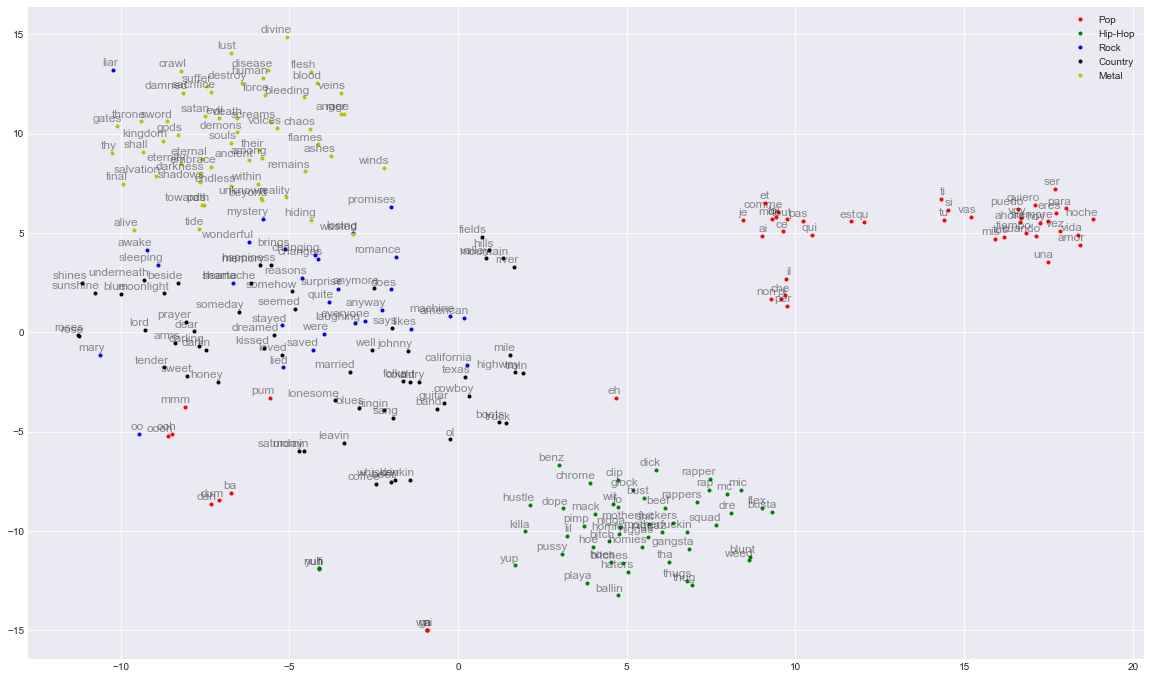

In [354]:
plt.figure(figsize=(20,12))

x = X_embedded[:,0];
y = X_embedded[:,1];

for i,genre in enumerate(genres):
    ids = np.where( word_genre==genre )[0]
    plt.plot(x[ids], y[ids], '.', color=colors[i], label=genre)
for i, word in enumerate(words):
    plt.annotate(word, alpha=0.5, xy=(x[i], y[i]), xytext=(5, 2),
                 textcoords='offset points', ha='right', va='bottom', size=12)
plt.legend();

## Text Classification
In this section, you'll build a text classifier, determining the genre of a song based on its lyrics.

### Text classification using Bag-of-Words
Build a Naive Bayes classifier based on the bag of Words.  
You will need to divide your dataset into a train and test sets.

In [413]:
from sklearn.feature_extraction.text import CountVectorizer
count_vect = CountVectorizer()

X_train, X_test, y_train, y_test = \
  train_test_split(df.sent, df.genre, test_size=0.1, random_state=0) # We used 10,000 songs from each category - 1,000 songs in the test set seem like a lot. 

X_train_counts = count_vect.fit_transform([" ".join(sent) for sent in X_train])
X_test_counts = count_vect.transform([" ".join(sent) for sent in X_test])

In [414]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import confusion_matrix, classification_report

model = MultinomialNB(alpha = 1)
model.fit(X_train_counts, y_train)

MultinomialNB(alpha=1, class_prior=None, fit_prior=True)

Show the confusion matrix.

In [415]:
# Predict
y_pred = model.predict(X_train_counts)
cm = confusion_matrix(y_train, y_pred)
print( pd.DataFrame(cm, index=genres, columns=genres) )

y_pred = model.predict(X_test_counts)
cm = confusion_matrix(y_test, y_pred)
print( pd.DataFrame(cm, index=genres, columns=genres) )

          Pop  Hip-Hop  Rock  Country  Metal
Pop      6534       60   150      239    551
Hip-Hop   243     7016   198      798    550
Rock      181      267  6600      267   1233
Country  1834      557   433     4016   2643
Metal    1931      432   933      779   6534
         Pop  Hip-Hop  Rock  Country  Metal
Pop      639        8    19       23     85
Hip-Hop   32      781    21       96     64
Rock      21       46   685       35    179
Country  211       87    57      374    333
Metal    286       69   169      119    559


Show the classification report - precision, recall, f1 for each class.

In [416]:
print( classification_report(y_test, y_pred ))

             precision    recall  f1-score   support

    Country       0.54      0.83      0.65       774
    Hip-Hop       0.79      0.79      0.79       994
      Metal       0.72      0.71      0.71       966
        Pop       0.58      0.35      0.44      1062
       Rock       0.46      0.47      0.46      1202

avg / total       0.61      0.61      0.60      4998



In [2]:
import seaborn as sns
sns.heatmap( confusion_matrix(y_test, y_pred) )

NameError: name 'confusion_matrix' is not defined

### Text classification using Word Vectors
#### Average word vectors
Do the same, using a classifier that averages the word vectors of words in the document.

In [417]:
X_train_vec = np.array([sum(w2v[w] for w in sent if w in w2v) for sent in X_train])
X_test_vec = np.array([sum(w2v[w] for w in sent if w in w2v) for sent in X_test])

In [428]:
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression

model = LogisticRegression()
model.fit(X_train_vec, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [429]:
# Predict
y_pred = model.predict(X_train_vec)
cm = confusion_matrix(y_train, y_pred)
print( pd.DataFrame(cm, index=genres, columns=genres) )

y_pred = model.predict(X_test_vec)
cm = confusion_matrix(y_test, y_pred)
print( pd.DataFrame(cm, index=genres, columns=genres) )

          Pop  Hip-Hop  Rock  Country  Metal
Pop      4700       64   250      743   1777
Hip-Hop   135     6872   293      921    584
Rock      170      225  6502      371   1280
Country  1174      660   725     4348   2576
Metal    1758      269  1818     1877   4887
         Pop  Hip-Hop  Rock  Country  Metal
Pop      483        7    29       80    175
Hip-Hop   16      784    25      104     65
Rock      16       28   742       38    142
Country  116       74    74      515    283
Metal    221       27   230      208    516


#### TfIdf Weighting
Do the same, using a classifier that averages the word vectors of words in the document, weighting each word by its TfIdf.


In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
tfidf = TfidfVectorizer(smooth_idf=True, sublinear_tf=False, norm=None, analyzer='word')
X_train_tfidf = tfidf_vect.fit_transform([" ".join(sent) for sent in X_train])
X_test_tfidf = tfidf_vect.transform([" ".join(sent) for sent in X_test])

In [ ]:
X_train_vec = np.array([sum(w2v[w] for w in sent if w in w2v) for sent in X_train])
X_test_vec = np.array([sum(w2v[w] for w in sent if w in w2v) for sent in X_test])

### Text classification using ConvNet
Do the same, using a ConvNet.  
The ConvNet should get as input a 2D matrix where each column is an embedding vector of a single word, and words are in order. Use zero padding so that all matrices have a similar length.  
Some songs might be very long. Trim them so you keep a maximum of 128 words (after cleaning stop words and rare words).  
Initialize the embedding layer using the word vectors that you've trained before, but allow them to change during training.  

Extra: Try training the ConvNet with 2 slight modifications:
1. freezing the the weights trained using Word2vec (preventing it from updating)
1. random initialization of the embedding layer

You are encouraged to try this question on your own.  

You might prefer to get ideas from the paper "Convolutional Neural Networks for Sentence Classification" (Kim 2014, [link](https://arxiv.org/abs/1408.5882)).

There are several implementations of the paper code in PyTorch online (see for example [this repo](https://github.com/prakashpandey9/Text-Classification-Pytorch) for a PyTorch implementation of CNN and other architectures for text classification). If you get stuck, they might provide you with a reference for your own code.